In [ ]:
import gym
import torch

from src.Learner.AWAC import AWAC
from src.Learner.DQN import DQN
from src.Learner.Random import DiscreteRandomAgent
from src.nn.MLP import MLP
from src.utils.memory import ReplayMemory
from src.utils.train_utils import prepare_training_inputs

import matplotlib.pyplot as plt

In [18]:
gamma = 0.9
memory_size = 500000

In [ ]:
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

In [ ]:
qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

In [20]:
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

## Prepare offline data

In [21]:
use_expert = True
if use_expert:    
    qnet = MLP(4, 2, num_neurons=[128])
    qnet_target = MLP(4, 2, num_neurons=[128])
    dqn = DQN(4, 1, qnet=qnet, qnet_target=qnet_target, lr=1e-4, gamma=gamma, epsilon=1.0)
    state_dict = torch.load('dqn_agent.pt')
    
    # make trained agent slightly dumb
    # to simulate the realistic scenario where we don't have 'perfect' policy
    # but good enough policy.
    
    state_dict['epsilon'] = dqn.epsilon * .4 
    dqn.load_state_dict(state_dict)    
    offline_agent = dqn
    offline_budget = 50
else:
    offline_agent = DiscreteRandomAgent(2)
    offline_budget = 300

online_budget = offline_budget

In [22]:
cum_rs = []
for n_epi in range(offline_budget):
    s, info = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = offline_agent.get_action(s)
        ns, r, term, trun, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(term).view(1, 1),
                      torch.tensor(trun).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if term or trun:
            cum_rs.append(cum_r)
            break

/home/bms/anaconda3/envs/AWAC/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([0.01437126, 0.0251497 , 0.00958084, 0.00479042, 0.0011976 ,
        0.0011976 , 0.0011976 , 0.        , 0.0011976 , 0.0011976 ]),
 array([ 11. ,  27.7,  44.4,  61.1,  77.8,  94.5, 111.2, 127.9, 144.6,
        161.3, 178. ]),
 <BarContainer object of 10 artists>)

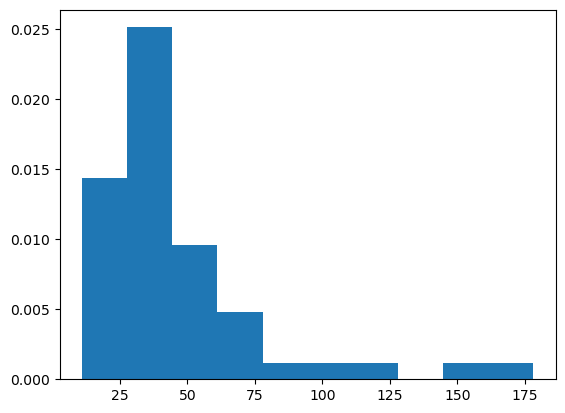

In [23]:
plt.hist(cum_rs, density=True, label='expert')

## offline training

In [24]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, term, trun = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)
    critic_loss = agent.update_critic(s,a,r,ns,term,trun)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


AWAC(
  (critic): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (critic_target): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (actor): MLP(
    (hidden_act): ReLU()
    (out_act): Identity()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2,

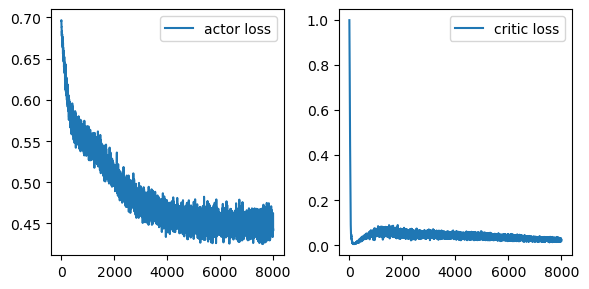

In [26]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot([loss.cpu().detach().numpy() for loss in actor_losses], label='actor loss')
axes[0].legend()
axes[1].plot([loss.cpu().detach().numpy() for loss in critic_losses], label='critic loss')
axes[1].legend()
fig.tight_layout()

## check offline perf

In [27]:
awac_cum_rs = []
num_runs = 500
for n_epi in range(num_runs):
    s, info = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, term, trun, info = env.step(a)

        s = ns
        cum_r += 1
        if term or trun:
            awac_cum_rs.append(cum_r)
            break

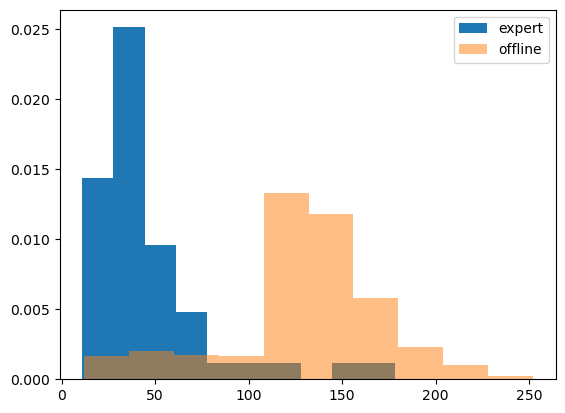

In [28]:
plt.hist(cum_rs, density=True, label='expert')
plt.hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
plt.legend()

## Online fine tuning

In [29]:
agent.to('cpu')

AWAC(
  (critic): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (critic_target): MLP(
    (hidden_act): ReLU()
    (out_act): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
      (5): ReLU()
    )
  )
  (actor): MLP(
    (hidden_act): ReLU()
    (out_act): Identity()
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2,

In [30]:
refresh_memory = False
if refresh_memory:
    memory.reset()

In [31]:
online_budget = 600
online_awac_cum_rs = []
for n_epi in range(online_budget):
    s, info = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, term, trun, info = env.step(a)
        
        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(term).view(1, 1),
                      torch.tensor(trun).view(1, 1))
        memory.push(experience)
        
        s = ns
        cum_r += 1
        if term or trun:
            online_awac_cum_rs.append(cum_r)
            break
    
    if len(memory) >= batch_size:
        sampled_exps = memory.sample(batch_size)
        _s, _a, _r, _ns, _term, _trun = prepare_training_inputs(sampled_exps, device=fit_device)
        agent.to(fit_device)
        critic_loss = agent.update_critic(_s,_a,_r,_ns,_term,_trun)
        actor_loss = agent.update_actor(_s,_a)
        critic_losses.append(critic_loss.detach())
        actor_losses.append(actor_loss.detach())
        agent.to('cpu')

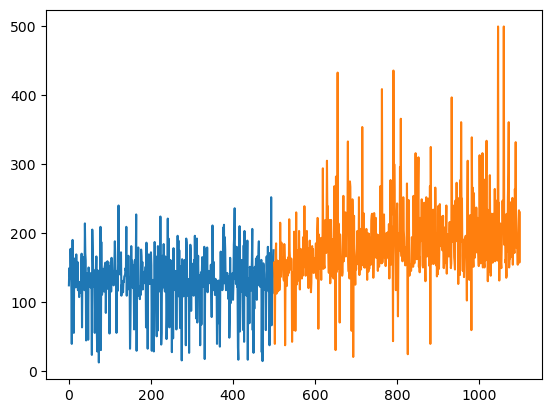

In [32]:
plt.plot(range(len(awac_cum_rs)), awac_cum_rs)
plt.plot(range(len(awac_cum_rs), 
               len(awac_cum_rs + online_awac_cum_rs)), 
         online_awac_cum_rs)

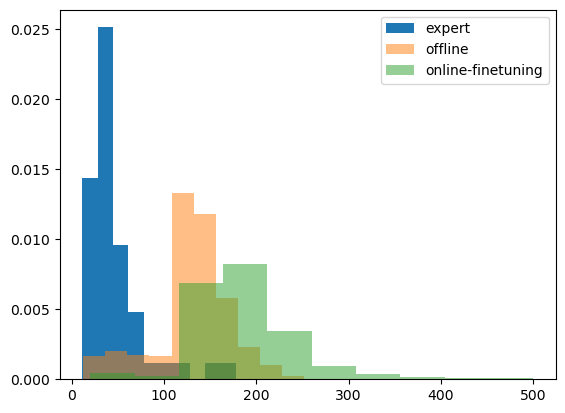

In [33]:
plt.hist(cum_rs, density=True, label='expert')
plt.hist(awac_cum_rs, alpha=0.5, density=True, label='offline')
plt.hist(online_awac_cum_rs, alpha=0.5, density=True, label='online-finetuning')
plt.legend()